# QuTiP example: Correlation functions and spectrum of a atom-cavity system

J.R. Johansson and P.D. Nation

For more information about QuTiP see [http://qutip.org](http://qutip.org)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np

In [3]:
from qutip import *

## Model and parameters

We use the Jaynes-Cumming model of a single two-level atom interacting with a single-mode cavity via a dipole interaction and under the rotating wave approximation.

In [4]:
kappa = 2
gamma = 0.2
g = 5
wc = 0 
w0 = 0 
wl = 0
N = 5 
E = 0.5

tlist = np.linspace(0,10.0,500)

## Correlation functions and spectrum using `eseries`

In [5]:
def probcorr(E,kappa,gamma,g,wc,w0,wl,N):
    #
    # returns the two-time correlation and covariance of the intracavity 
    # field as exponential series for the problem of a coherently driven 
    # cavity with a two-level atom
    #
    # E = amplitude of driving field, kappa = mirror coupling,
    # gamma = spontaneous emission rate, g = atom-field coupling,
    # wc = cavity frequency, w0 = atomic frequency, wl = driving field frequency,
    # N = size of Hilbert space for intracavity field (zero to N-1 photons)
    #  

    # Hamiltonian
    a  = tensor(destroy(N),qeye(2))
    sm = tensor(qeye(N),destroy(2))
    H = (w0-wl)*sm.dag()*sm + (wc-wl)*a.dag()*a + 1j*g*(a.dag()*sm - sm.dag()*a) \
        + E*(a.dag()+a)

    # collapse operators
    C1 = np.sqrt(2*kappa) * a
    C2 = np.sqrt(gamma)   * sm.dag()
    c_op_list = [C1, C2]

    # Calculate the Liouvillian
    L = liouvillian(H, c_op_list)

    # Find steady state density matrix and field
    rhoss = steadystate(L);

    ass = expect(a,rhoss);
 
    # Initial condition for regression theorem
    arho = a*rhoss;

    # Solve differential equation with this initial condition
    solES = ode2es(L,arho);
   
    # Find trace(a' * solution)
    corrES = expect(a.dag(),solES);

    # Calculate the covariance by subtracting product of means
    covES = corrES - np.real(np.conjugate(ass) * ass)

    return corrES, covES

In [6]:
corrES, covES = probcorr(E, kappa, gamma, g, wc, w0, wl, N)

In [7]:
corr= esval(corrES, tlist)
cov = esval(covES, tlist)

### Correlation function

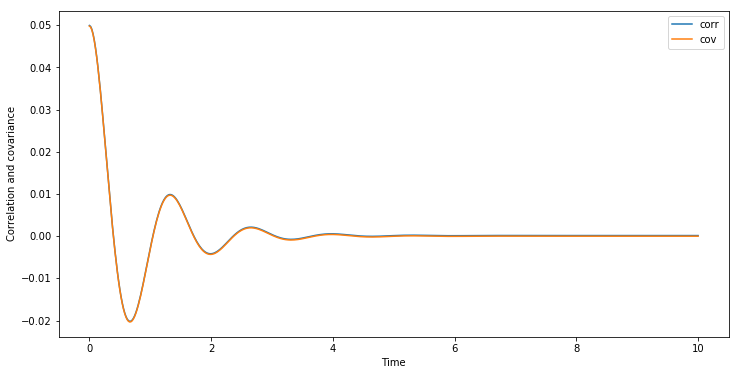

In [8]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(tlist, np.real(corr))
ax.plot(tlist, np.real(cov))
ax.set_xlabel('Time')
ax.set_ylabel('Correlation and covariance')
ax.legend(("corr", "cov"));

### Spectrum

In [9]:
wlist = np.linspace(-10,10,200)
Ps = esspec(covES, wlist)

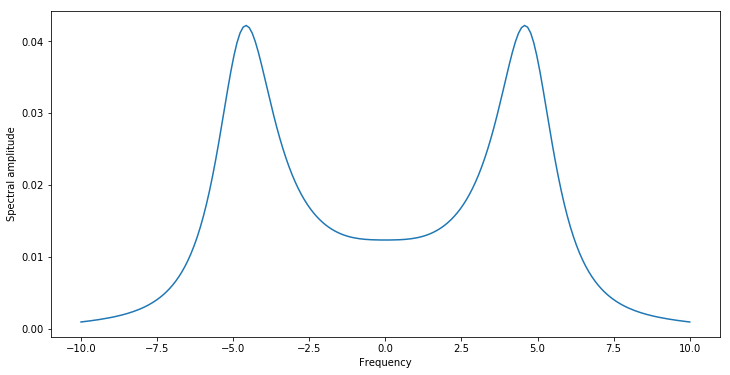

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(wlist, np.real(Ps))
ax.set_xlabel('Frequency')
ax.set_ylabel('Spectral amplitude');

## Comparison: Correlation function using `correlation_ss` with `mesolve` and `eseries`

In [11]:
def calc_correlation(E, kappa, gamma, g, wc, w0, wl, N, tlist):
    #
    # returns the two-time correlation of the intracavity field as exponential
    # series for the problem of a coherently driven cavity with a two-level atom
    #
    # E = amplitude of driving field, kappa = mirror coupling,
    # gamma = spontaneous emission rate, g = atom-field coupling,
    # wc = cavity frequency, w0 = atomic frequency, wl = driving field frequency,
    # N = size of Hilbert space for intracavity field (zero to N-1 photons)
    #  

    # Define cavity field and atomic operators
    a  = tensor(destroy(N),qeye(2))
    sm = tensor(qeye(N),sigmam())

    # Hamiltonian
    H = (w0-wl)*sm.dag()*sm + (wc-wl)*a.dag()*a + 1j*g*(a.dag()*sm - sm.dag()*a) \
        + E*(a.dag()+a)

    # collapse operators
    C1 = np.sqrt(2*kappa)*a
    C2 = np.sqrt(gamma)*sm.dag()

    A = a 

    corr_ode = correlation_2op_1t(H, None, tlist, [C1, C2], A.dag(), A, solver="me")
    corr_es  = correlation_2op_1t(H, None, tlist, [C1, C2], A.dag(), A, solver="es")

    print("real corr at 0 [me]:", corr_ode[0])
    print("real corr at 0 [es] :", corr_es[0])

    return corr_ode, corr_es

In [12]:
corr1, corr2 = calc_correlation(E, kappa, gamma, g, wc, w0, wl, N, tlist)

real corr at 0 [me]: (0.0499554840591+0j)
real corr at 0 [es] : (0.0499554840591-8.67361737988e-19j)


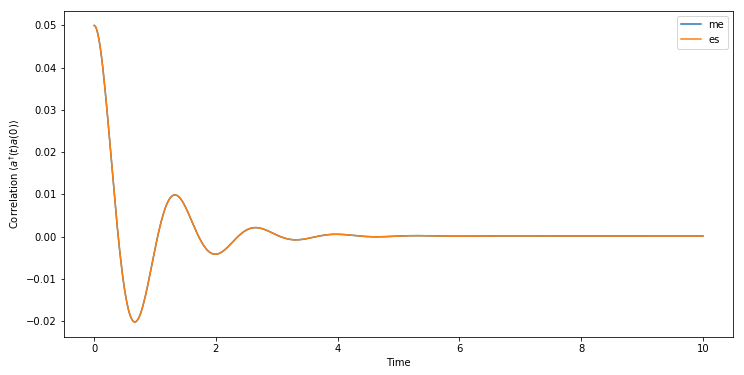

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(tlist, np.real(corr1),
        tlist, np.real(corr2))
ax.set_xlabel('Time')
ax.set_ylabel(r'Correlation $\langle a^\dag(t)a(0)\rangle$')
ax.legend(("me", "es"));

## Correlation functions and spectrum at two different coupling strengths

In [14]:
def calc_spectrum(N, wc, wa, g, kappa, gamma, tlist, wlist):

    # Hamiltonian
    a  = tensor(destroy(N), qeye(2))
    sm = tensor(qeye(N), destroy(2))
    H = wc * a.dag() * a + wa * sm.dag() * sm + g * (a.dag() * sm + a * sm.dag())
        
    # collapse operators
    c_op_list = []

    n_th_a = 0.5
    rate = kappa * (1 + n_th_a)
    if rate > 0.0:
        c_op_list.append(np.sqrt(rate) * a)

    rate = kappa * n_th_a
    if rate > 0.0:
        c_op_list.append(np.sqrt(rate) * a.dag())

    rate = gamma
    if rate > 0.0:
        c_op_list.append(np.sqrt(rate) * sm)

    A = a.dag() + a
    B = A

    # calculate the power spectrum
    corr = correlation_2op_1t(H, None, tlist, c_op_list, A, B, solver='es')

    # calculate the power spectrum
    spec = spectrum(H, wlist, c_op_list, A, B)

    return corr, spec

In [15]:
N = 4                  # number of cavity fock states
wc = 1.00 * 2 * np.pi  # cavity frequency
wa = 1.00 * 2 * np.pi  # atom frequency
g  = 0.10 * 2 * np.pi  # coupling strength
kappa = 1.0            # cavity dissipation rate
gamma = 0.2            # atom dissipation rate

wlist = np.linspace(0, 4 * np.pi, 200)
tlist = np.linspace(0, 15, 500)

In [16]:
corr1, spec1 = calc_spectrum(N, wc, wa, g, kappa, gamma, tlist, wlist)
corr2, spec2 = calc_spectrum(N, wc, wa, 0, kappa, gamma, tlist, wlist)

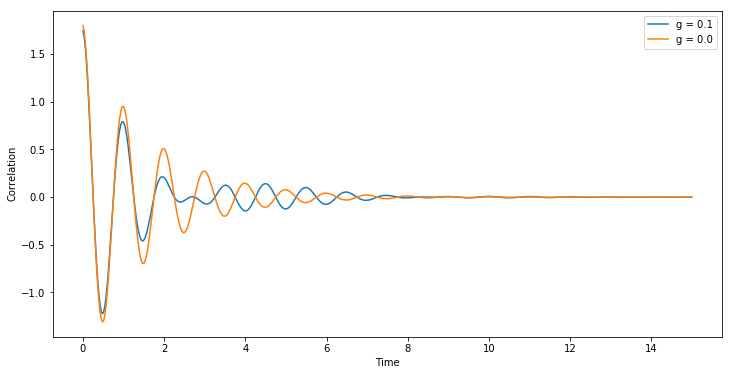

In [17]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(tlist, np.real(corr1),
        tlist, np.real(corr2))
ax.set_xlabel('Time')
ax.set_ylabel('Correlation')
ax.legend(("g = 0.1", "g = 0.0"));

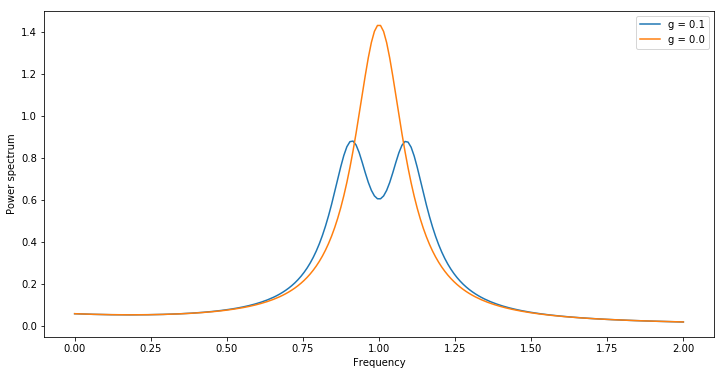

In [18]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(wlist/(2*np.pi), abs(spec1), 
        wlist/(2*np.pi), abs(spec2))
ax.set_xlabel('Frequency')
ax.set_ylabel('Power spectrum')
ax.legend(("g = 0.1", "g = 0.0"));

## Versions

In [19]:
from qutip.ipynbtools import version_table

version_table()

Software,Version
QuTiP,4.2.0
Numpy,1.13.1
SciPy,0.19.1
matplotlib,2.0.2
Cython,0.25.2
Number of CPUs,2
BLAS Info,INTEL MKL
IPython,6.1.0
Python,"3.6.1 |Anaconda custom (x86_64)| (default, May 11 2017, 13:04:09) [GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]"
OS,posix [darwin]
